###### Esri Challenge
* 항공 사진 이미지를 기반으로 자동차와 수영장을 Object Detection

#### annotation 디렉토리와 image 디렉토리 설정. 

In [ ]:
# annotation과 image 디렉토리 설정. annotation디렉토리에 있는 파일 확인. 
import os
from pathlib import Path

HOME_DIR = str(Path.home())
ANNO_DIR = os.path.join(HOME_DIR, 'DLCV/data/poolncar/training_data/training_data/labels')
IMAGE_DIR = os.path.join(HOME_DIR, 'DLCV/data/poolncar/training_data/training_data/images')
print(ANNO_DIR)

files = os.listdir(ANNO_DIR)
print('파일 개수는:',len(files))
print(files)

#### XML 형태의 annotation을 csv 형태로 변환
* class 명은 1과 2
* Object가 작아서 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 정수형으로 변환하되 ceil 적용하여 조금 이동하여 변환

In [ ]:
!cat ~/DLCV/data/poolncar/training_data/training_data/labels/000000040.xml

In [ ]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import math

classes = ['1','2']

# XML 파일을 Pandas DataFrame으로 변환 한뒤 DataFrame의 to_csv()를 이용하여 csv 파일로 생성하고 DataFrame반환
def xml_to_csv(xml_files, output_filename):
    xml_list = []
    # xml 확장자를 가진 모든 파일의 절대 경로로 xml_file할당. 
    for xml_file in xml_files:
        # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        if root.iter('object') is not None:
            for obj in root.iter('object'):
                full_image_name = os.path.join(IMAGE_DIR, root.find('filename').text)
                cls = obj.find('name').text
                if cls not in classes:
                    continue

                xmlbox = obj.find('bndbox')
                # 위치 좌표가 소수점까지 표시됨. pixel 단위는 정수형이므로 변환하되 ceil로 조금 이동하여 변환
                x1 = math.ceil(float(xmlbox.find('xmin').text))
                y1 = math.ceil(float(xmlbox.find('ymin').text))
                x2 = math.ceil(float(xmlbox.find('xmax').text))
                y2 = math.ceil(float(xmlbox.find('ymax').text))
                if x1 == x2 or y1 == y2:
                    continue
                value = (full_image_name, x1, y1, x2, y2, cls)

                # object별 정보를 tuple형태로 xml_list에 저장. 
                xml_list.append(value)
    # 모든 object별 정보를 DataFrame으로 생성하고 이를 CSV 파일로 생성하고 DataFrame은 반환. 
    column_name = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    xml_df.to_csv(output_filename, index=None, header=None)
    return xml_df

#### train과 validation 용으로 파일 분리. 
* validation은 약 10% 크기

In [ ]:
import numpy as np
np.random.seed(0)

all_xml_files = glob.glob(ANNO_DIR + '/*.xml')
file_cnt = len(all_xml_files)
valid_size = file_cnt//10
valid_index = np.random.choice(file_cnt, valid_size)

valid_files = [ all_xml_files[i] for i in valid_index ]
train_files = [xml_file for xml_file in all_xml_files if xml_file not in valid_files ]

#### CSV 파일로 전체/학습/검증 annotation 저장. 

In [ ]:
# annotation 디렉토리 밑에 csv로 저장
all_df = xml_to_csv(all_xml_files, os.path.join(ANNO_DIR, 'poolncar_anno.csv'))
train_df = xml_to_csv(train_files, os.path.join(ANNO_DIR, 'poolncar_train_anno.csv'))
valid_df = xml_to_csv(valid_files, os.path.join(ANNO_DIR, 'poolncar_valid_anno.csv'))

In [ ]:
train_df.shape, valid_df.shape

#### class name과 class id 매핑 파일을 ANNO_DIR에 poolncar_class.txt 로 생성
* class name은 1(car)과 2(pool)로 되어 있음. id는 0 부터 시작해야 하므로
* 1, 0  
  2, 1

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

test_image = cv2.imread(os.path.join(HOME_DIR,'DLCV/data/poolncar/training_data/training_data/images/000000040.jpg'))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
plt.figure(figsize=(12, 12))
plt.imshow(test_image)

### Esri 데이터 세트 학습

In [ ]:
import cv2
import numpy as np
import os
from os import listdir, walk
import math
import tensorflow as tf
from os.path import join

from keras_retinanet import models
from keras_retinanet.bin.train import create_generators,create_models,create_callbacks
from keras_retinanet.models import backbone,load_model,convert_model
from keras_retinanet.utils.config import read_config_file,parse_anchor_parameters
from keras_retinanet.utils.visualization import draw_boxes

#from imgaug import augmenters as iaa

tf.set_random_seed(31) # SEEDS MAKE RESULTS MORE REPRODUCABLE
np.random.seed(17)

#### anchor  box 정보를 config.ini에 저장. 
* Object 들이 너무 작기 때문에 default anchor로 수행 성능이 저하될 수 있음. 
* anchor 최적화 스크립트 수행 후 anchor 값을 config.init에 설정할 수 있음. 
*  Improving RetinaNet for CT Lesion Detection with Dense Masks from Weak RECIST Labels에 사용된 anchor box 최적화 모듈을 https://github.com/martinzlocha/anchor-optimization/ 에서 다운로드 가능 
* 여기서는 Winning 솔루션으로 설정된 anchor box를 그대로 사용함. 

#### Default anchor box 설정
sizes   = 32 64 128 256 512
strides = 8 16 32 64 128
ratios  = 0.5 1 2 3
scales  = 1 1.2 1.6

#### Winning 솔루션으로 설정된 anchor box , 자동차의 경우 좀더 높이가 강조된 anchor box를 설정. 
sizes   = 32 64 128 256 512
strides = 8 16 32 64 128
ratios  = 0.25 0.5 0.75 1 1.5 2 4 6 8 10
scales  = 0.5 1 2


In [ ]:
with open('./keras-retinanet/snapshots/config_poolncar.ini','w') as f:
    f.write('[anchor_parameters]\nsizes   = 32 64 128 256 512\nstrides = 8 16 32 64 128\nratios  = 0.25 0.5 0.75 1 1.5 2 4 6 8 10\nscales  = 0.5 1 2\n')

#### 주요 환경 설정
* 학습과 검증을 위한 csv annotation설정
* backbone은 resnet50
* batch_size=8
* epochs=35

In [ ]:
b = backbone('resnet50')
files = os.listdir(IMAGE_DIR)

class args:
    batch_size = 8
    config = read_config_file('./keras-retinanet/snapshots/config_poolncar.ini')
    random_transform =True # Image augmentation
    annotations = os.path.join(ANNO_DIR, 'poolncar_train_anno.csv')
    #val_annotations = None
    val_annotations = os.path.join(ANNO_DIR, 'poolncar_valid_anno.csv')
    classes = os.path.join(ANNO_DIR, 'poolncar_class.txt')
    # 기본값은 min_side=800, max_side=1333
    image_min_side = 672
    image_max_side = 672
    no_resize=None
    dataset_type = 'csv'
    tensorboard_dir = ''
    evaluation = False
    snapshots = True
    snapshot_path = './keras-retinanet/snapshots/poolncar'
    backbone = 'resnet50'
    epochs = 35
    steps = len(files)//(batch_size)
    weighted_average = True

#### 학습용 DataGenerator, 검증용 DataGenerator생성

In [ ]:
train_gen,valid_gen = create_generators(args,b.preprocess_image)

#### 학습과 예측 기반 모델 생성
* Resnet50 backend 기반 모델 생성하고 이를 반환
* 단일 GPU 모델에서는 model과 training_model이 서로 같음

In [ ]:
model, training_model, prediction_model = create_models(
            backbone_retinanet=b.retinanet,
            num_classes=train_gen.num_classes(),
            weights=None,
            multi_gpu=False,
            freeze_backbone=True,
            lr=1e-3,
            config=args.config
        )

#### callback 생성. 

In [ ]:
callbacks = create_callbacks(
    model,
    training_model,
    prediction_model,
    valid_gen,
    args,
)

#### training 모델에 최초 weight 로딩은 pretrained된 coco 모델의 weight값으로 로딩

In [ ]:
training_model.load_weights('./keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5',skip_mismatch=True,by_name=True)

#### 학습 수행
* 주어진 epoch만큼, callback을 적용하며 training 모델의 학습 수행. 

In [ ]:
training_model.fit_generator(generator=train_gen,
        steps_per_epoch=args.steps,
        epochs=args.epochs,
        verbose=1,
        validation_data=valid_gen, 
        callbacks=callbacks)

####  convert_model.py를 이용하여 가장 마지막에 학습된 모델을 inference모델로 변환

In [ ]:
# !cd ./keras-retinanet/snapshots; ls -lia
# export poolncar_dir=~/DLCV/Detection/retina/keras-retinanet/snapshots
#./keras_retinanet/bin/convert_model.py --config=$poolncar_dir/config_poolncar.ini $poolncar_dir/poolncar/resnet50_csv_35.h5 $poolncar_dir/poolncar/poolncar_inference.h5

In [ ]:
model_path = os.path.join('keras-retinanet','snapshots/poolncar/poolncar_inference.h5')
print(model_path)
# load retinanet model
poolncar_retina_model = models.load_model(model_path, backbone_name='resnet50')

#### 또는 API를 이용하여 가장 마지막에 학습된 모델을 inference모델로 변환

In [ ]:
import os
from os import listdir, walk
from os.path import join
from keras_retinanet.bin.train import create_models
from keras_retinanet.models import backbone,convert_model
from keras_retinanet.utils.config import read_config_file,parse_anchor_parameters
import numpy as np
import keras
import math
import tensorflow as tf
tf.set_random_seed(31)
np.random.seed(17)

model, training_model, prediction_model = create_models(
            backbone_retinanet=backbone('resnet50').retinanet,
            num_classes=2,
            weights=None,
            multi_gpu=False,
            freeze_backbone=False,
            lr=1e-3,
            config=read_config_file('./keras-retinanet/snapshots/config_poolncar.ini')
        )

training_model.load_weights('./keras-retinanet/snapshots/poolncar/resnet50_csv_35.h5')
poolncar_retina_model = convert_model(training_model,anchor_params=parse_anchor_parameters(read_config_file('./keras-retinanet/snapshots/config_poolncar.ini')))

#### inference 모델을 이용하여 Object Detection 수행. 

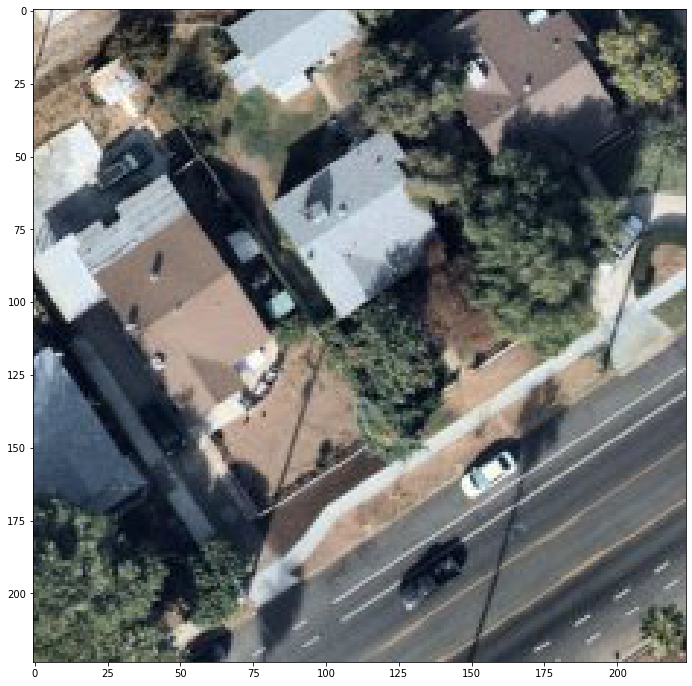

In [34]:
from keras_retinanet.utils.image import read_image_bgr

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(read_image_bgr(os.path.join(IMAGE_DIR, '000000040.jpg')), cv2.COLOR_BGR2RGB))

In [37]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

def get_detected_image_retina(model, img_array, convert_RGB=True, is_print=True):
    
    # copy to draw on
    draw = img_array.copy()
    if convert_RGB:
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    img_array = preprocess_image(img_array)
    # 학습시 사용된 image resize를 적용. 
    img_array, scale = resize_image(img_array, 672, 672)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(img_array, axis=0))
    if is_print:
        print("object detection 처리 시간: ", round(time.time() - start,5))
    
    # correct for image scale
    boxes /= scale
    
    classes=['1','2']

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        # scores are sorted so we can break
        print(score)
        if score < 0.5:
            break

        color = label_color(label)

        b = box.astype(int)

        caption = "{} {:.3f}".format(classes[label], score)
        print('caption:', caption)
        cv2.rectangle(draw, (box[0],box[1]), (box[2], box[3]), color, thickness=2)
        cv2.putText(draw, caption, (b[0], b[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    if is_print:
        print("이미지 processing 시간2: ", round(time.time() - start,5))
    
    return draw

object detection 처리 시간:  0.0557
0.8034764
caption: 1 0.803
0.75435966
caption: 1 0.754
0.64386857
caption: 1 0.644
0.6009304
caption: 1 0.601
0.54034543
caption: 1 0.540
0.4701228
이미지 processing 시간2:  0.05793


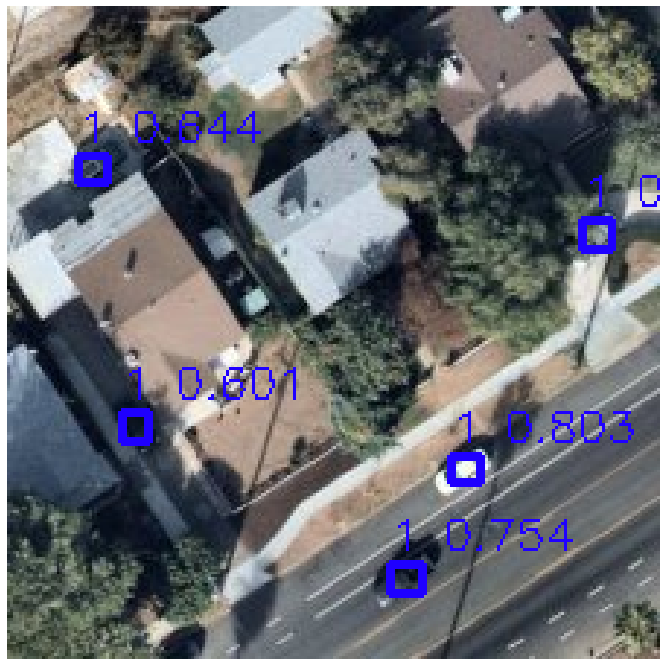

In [38]:
img_array  = cv2.imread(os.path.join(IMAGE_DIR, '000000040.jpg'))
detected_image = get_detected_image_retina(poolncar_retina_model,img_array, convert_RGB=True, is_print=True)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(detected_image)
plt.show()

#### validation dataset 기반으로 mAP 계산

In [39]:
import os

class args:
    batch_size=8
    dataset_type='csv'
    score_threshold=0.05
    iou_threshold=0.3
    max_detections=100
    image_min_side=672
    image_max_side=672
    config=None
    annotations=os.path.join(ANNO_DIR, 'poolncar_valid_anno.csv')
    classes=os.path.join(ANNO_DIR, 'poolncar_class.txt')

In [40]:
from keras_retinanet.bin.evaluate import create_generator as eval_create_generator
from keras_retinanet.utils.eval import evaluate

generator = eval_create_generator(args)
average_precisions, inference_time = evaluate(
            generator,
            poolncar_retina_model,
            iou_threshold=args.iou_threshold,
            score_threshold=args.score_threshold,
            max_detections=args.max_detections,
            save_path=None
        )

Running network: 100% (360 of 360) |#####| Elapsed Time: 0:00:15 Time:  0:00:15
Parsing annotations: 100% (360 of 360) |#| Elapsed Time: 0:00:00 Time:  0:00:00


In [41]:
# print evaluation
total_instances = []
precisions = []
for label, (average_precision, num_annotations) in average_precisions.items():
    print('{:.0f} instances of class'.format(num_annotations),
          generator.label_to_name(label), 'with average precision: {:.4f}'.format(average_precision))
    total_instances.append(num_annotations)
    precisions.append(average_precision)

if sum(total_instances) == 0:
    print('No test instances found.')

print('Inference time for {:.0f} images: {:.4f}'.format(generator.size(), inference_time))

print('mAP using the weighted average of precisions among classes: {:.4f}'.format(sum([a * b for a, b in zip(total_instances, precisions)]) / sum(total_instances)))
print('mAP: {:.4f}'.format(sum(precisions) / sum(x > 0 for x in total_instances)))

1258 instances of class 1 with average precision: 0.8215
334 instances of class 2 with average precision: 0.8525
Inference time for 360 images: 0.0404
mAP using the weighted average of precisions among classes: 0.8280
mAP: 0.8370
